<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import KMNIST

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

In [142]:
trainset

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./KMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** кажется, что чем больше батч, меньшее число прохождений нам требуется на одну эпоху. С другой стороны упоминалось, что батчевание в целом уменьшает время, затрачиваемое на обучение, поскольку в каждом отдельном батче меньше данных. Вероятнее всего, при наличии достаточного количества CPU будем иметь рост скорости при росте батча.

P.S. Все это при условии, если под скоростью обучения не имелась в виду lerning rate.

Посмотрим на какую-нибудь картинку:

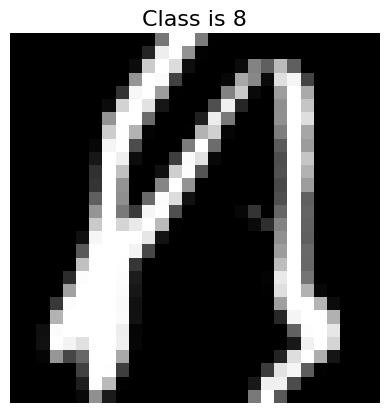

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





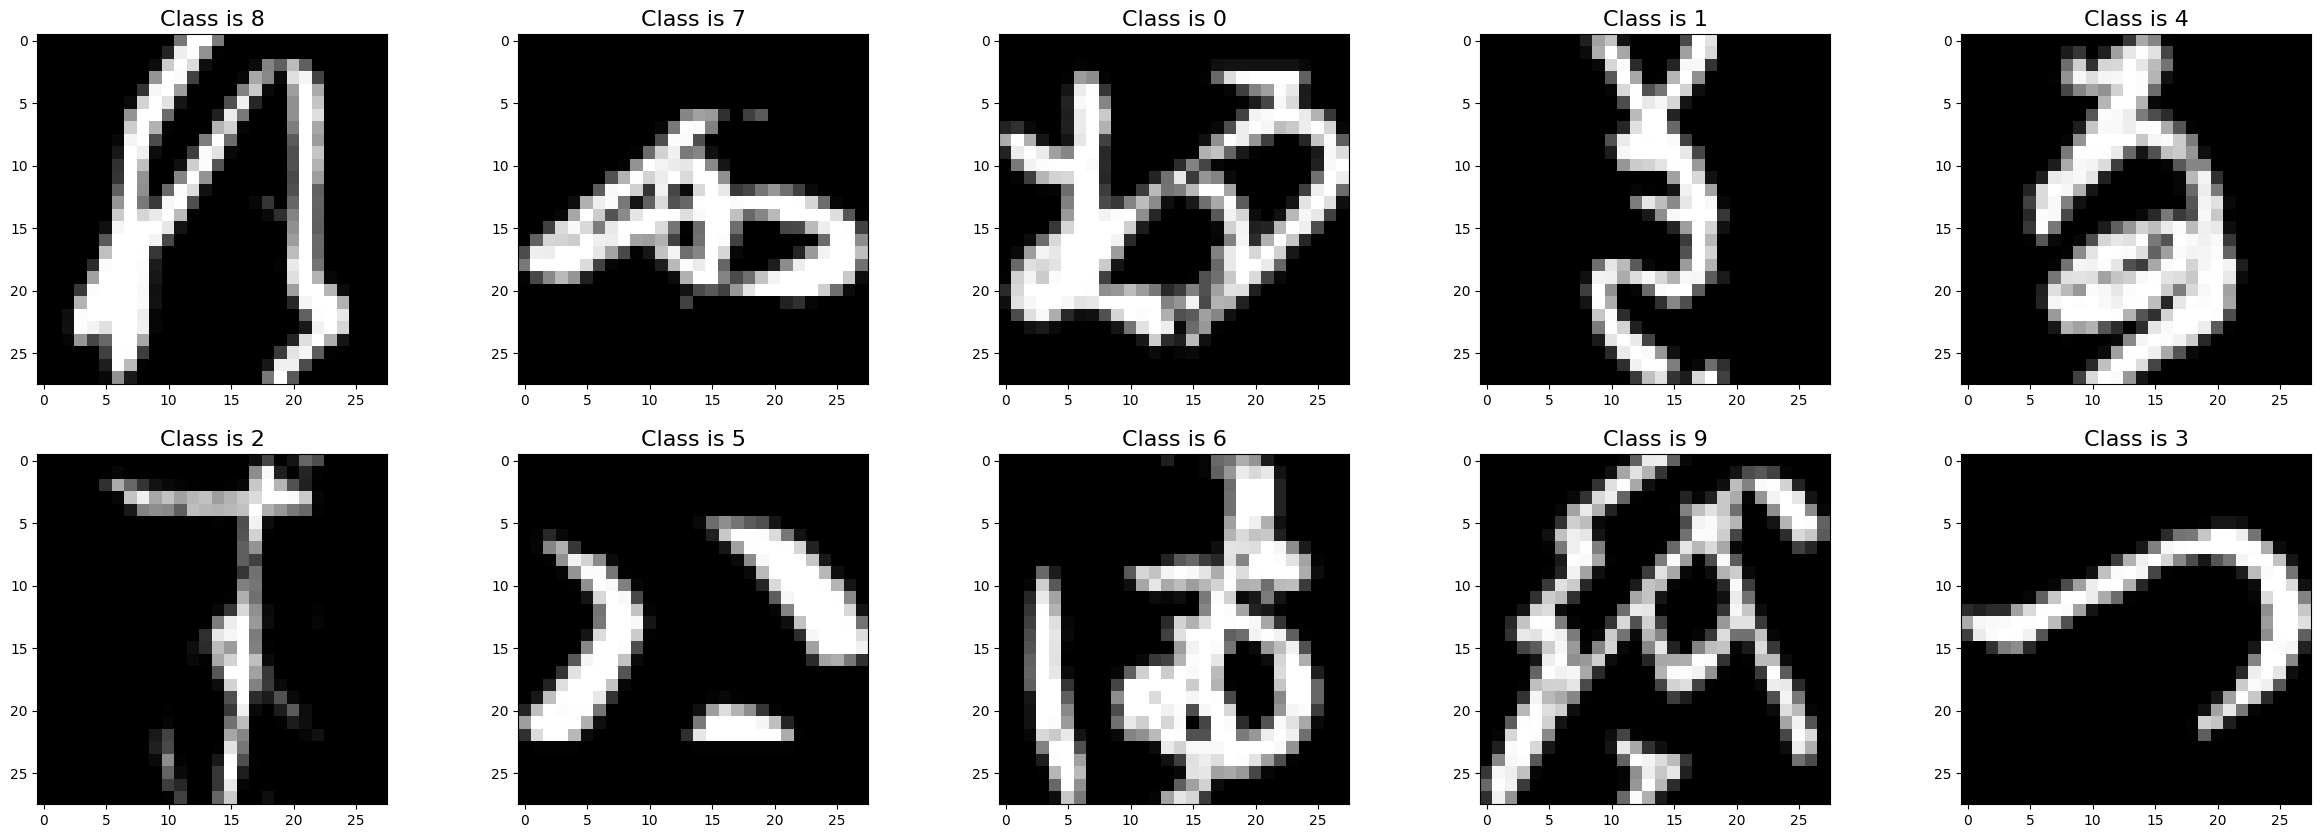

In [5]:
# Collecting data about class indexes
kminst_uniq_class = list(trainset.class_to_idx.values())
list_len = len(kminst_uniq_class)

# Choosing one examplar of every class
picture_list = []
point = 0
while len(picture_list) < list_len:
    cur_pict = trainset[point][1]
    if cur_pict in kminst_uniq_class:
        kminst_uniq_class.remove(cur_pict)
        picture_list.append(point)
    point += 1
    
# Creating plot
plt.figure(figsize=(30, 10))
point = 1
for number in picture_list:
    plt.subplot(2, 5, point)
    plt.imshow(trainset[number][0].view(28, 28).numpy(), cmap="gray")
    plt.title(f"Class is {trainset[number][1]}", fontsize=16)
    point += 1

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [6]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

- 28 * 28 * 256 весов в первом слое + 258 смещений
- 256 * 2128 весов во втором слое + 2128 смещений
- 2128 * 10 весов в третьем слое + 10 смещений

Итого: 769146 параметров

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [7]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [8]:
def studying(neuronet, loss_function, optimizer, n_epochs=10, lr=0.001):
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = neuronet(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
        
    return neuronet

In [9]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [10]:
neuronet1 = studying(fc_net, loss_function, optimizer)

Epoch=1 loss=0.6907
Epoch=2 loss=0.3141
Epoch=3 loss=0.2307
Epoch=4 loss=0.1753
Epoch=5 loss=0.1371
Epoch=6 loss=0.1081
Epoch=7 loss=0.0881
Epoch=8 loss=0.0689
Epoch=9 loss=0.0544
Epoch=10 loss=0.0427


In [11]:
get_accuracy(fc_net, testloader)

0.9059

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [26]:
# mean = trainset.data.view(60000, -1, 28, 28).to(torch.float32).mean(dim=(0, 2, 3))
# std = trainset.data.view(60000, -1, 28, 28).to(torch.float32).std(dim=(0, 2, 3))
mean = next(iter(trainloader))[0].mean()
std = next(iter(trainloader))[0].std()
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1909) tensor(0.3469)


In [27]:
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

In [28]:
fc_net_2 = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_2.parameters(), lr=3e-4)

In [29]:
neuronet_norm = studying(fc_net_2, loss_function, optimizer)

Epoch=1 loss=0.5289
Epoch=2 loss=0.2191
Epoch=3 loss=0.1473
Epoch=4 loss=0.1053
Epoch=5 loss=0.0780
Epoch=6 loss=0.0546
Epoch=7 loss=0.0401
Epoch=8 loss=0.0276
Epoch=9 loss=0.0195
Epoch=10 loss=0.0128


In [31]:
get_accuracy(fc_net_2, testloader)

0.9019

Плюс-минус тот же результат. Немного хуже, но на некоторых прогонах без нормализации было бы немного лучше.

Как изменилась `accuracy` после нормализации?

Все упало, accuracy снизилась в 9 раз. Вероятно, причина -- то, что появились отрицательные значения, которых быть не должно.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [26]:
class FCNet_s(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        logits = self.fc3(x)

        return logits

    
class FCNet_g(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        logits = self.fc3(x)

        return logits
    
    
class FCNet_t(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        logits = self.fc3(x)

        return logits

In [27]:
# Создадим объект модели
fc_net_s = FCNet_s()
fc_net_g = FCNet_g()
fc_net_t = FCNet_t()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer_s = torch.optim.Adam(fc_net_s.parameters(), lr=3e-4)
optimizer_g = torch.optim.Adam(fc_net_g.parameters(), lr=3e-4)
optimizer_t = torch.optim.Adam(fc_net_t.parameters(), lr=3e-4)

In [28]:
neuronet2 = studying(fc_net_s, loss_function, optimizer_s)

Epoch=1 loss=1.4298
Epoch=2 loss=0.6679
Epoch=3 loss=0.5246
Epoch=4 loss=0.4477
Epoch=5 loss=0.3949
Epoch=6 loss=0.3497
Epoch=7 loss=0.3149
Epoch=8 loss=0.2852
Epoch=9 loss=0.2615
Epoch=10 loss=0.2387


In [30]:
neuronet3 = studying(fc_net_g, loss_function, optimizer_g)

Epoch=1 loss=0.7437
Epoch=2 loss=0.3538
Epoch=3 loss=0.2681
Epoch=4 loss=0.2126
Epoch=5 loss=0.1716
Epoch=6 loss=0.1396
Epoch=7 loss=0.1140
Epoch=8 loss=0.0934
Epoch=9 loss=0.0779
Epoch=10 loss=0.0641


In [31]:
neuronet4 = studying(fc_net_t, loss_function, optimizer_t)

Epoch=1 loss=0.7545
Epoch=2 loss=0.4840
Epoch=3 loss=0.3555
Epoch=4 loss=0.2828
Epoch=5 loss=0.2337
Epoch=6 loss=0.1986
Epoch=7 loss=0.1708
Epoch=8 loss=0.1450
Epoch=9 loss=0.1280
Epoch=10 loss=0.1096


In [29]:
get_accuracy(fc_net_s, testloader)

0.8266

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

In [32]:
get_accuracy(fc_net_g, testloader)

0.9032

In [33]:
get_accuracy(fc_net_t, testloader)

0.8769

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [35]:
# Создадим объект модели
fc_net_ga = FCNet_g()
fc_net_gr = FCNet_g()
fc_net_gg = FCNet_g()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer_ga = torch.optim.Adam(fc_net_ga.parameters(), lr=3e-4)
optimizer_gr = torch.optim.RMSprop(fc_net_gr.parameters(), lr=3e-4)
optimizer_gg = torch.optim.Adagrad(fc_net_gg.parameters(), lr=3e-4)

In [37]:
neuronet5 = studying(fc_net_ga, loss_function, optimizer_ga)

Epoch=1 loss=0.7527
Epoch=2 loss=0.3550
Epoch=3 loss=0.2665
Epoch=4 loss=0.2110
Epoch=5 loss=0.1728
Epoch=6 loss=0.1395
Epoch=7 loss=0.1157
Epoch=8 loss=0.0965
Epoch=9 loss=0.0798
Epoch=10 loss=0.0659


In [38]:
neuronet6 = studying(fc_net_gr, loss_function, optimizer_gr)

Epoch=1 loss=0.5426
Epoch=2 loss=0.2841
Epoch=3 loss=0.2069
Epoch=4 loss=0.1568
Epoch=5 loss=0.1229
Epoch=6 loss=0.0974
Epoch=7 loss=0.0763
Epoch=8 loss=0.0611
Epoch=9 loss=0.0474
Epoch=10 loss=0.0371


In [39]:
neuronet7 = studying(fc_net_gg, loss_function, optimizer_gg)

Epoch=1 loss=1.4097
Epoch=2 loss=0.8600
Epoch=3 loss=0.7425
Epoch=4 loss=0.6855
Epoch=5 loss=0.6487
Epoch=6 loss=0.6226
Epoch=7 loss=0.6020
Epoch=8 loss=0.5864
Epoch=9 loss=0.5731
Epoch=10 loss=0.5617


In [40]:
get_accuracy(fc_net_ga, testloader)

0.9037

In [41]:
get_accuracy(fc_net_gr, testloader)

0.9084

In [42]:
get_accuracy(fc_net_gg, testloader)

0.7041

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [45]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x[x < 0] = 0
        # если элемент x < 0, то 0, если >= 0, то x

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [46]:
class FCNetCR(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)
        self.cr = CustomReLU()
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.cr(x)
        x = self.fc2(x)
        x = self.cr(x)
        logits = self.fc3(x)

        return logits

In [47]:
# Создадим объект модели
fc_netcr = FCNetCR()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_netcr.parameters(), lr=3e-4)

In [48]:
neuronet8 = studying(fc_netcr, loss_function, optimizer)

Epoch=1 loss=0.7033
Epoch=2 loss=0.3196
Epoch=3 loss=0.2290
Epoch=4 loss=0.1744
Epoch=5 loss=0.1353
Epoch=6 loss=0.1068
Epoch=7 loss=0.0863
Epoch=8 loss=0.0692
Epoch=9 loss=0.0545
Epoch=10 loss=0.0416


In [72]:
get_accuracy(fc_netcr, testloader)

0.9044

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

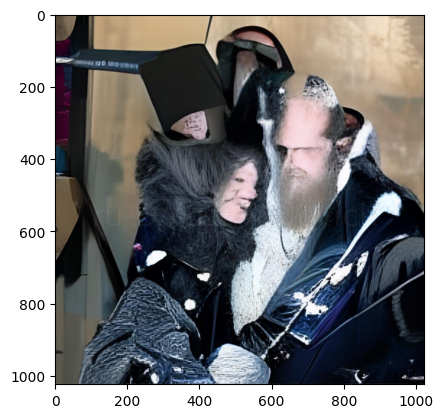

In [78]:
img1 = plt.imread("/home/asklepiad/Downloads/Belle.jpg")
_ = plt.imshow(img1)

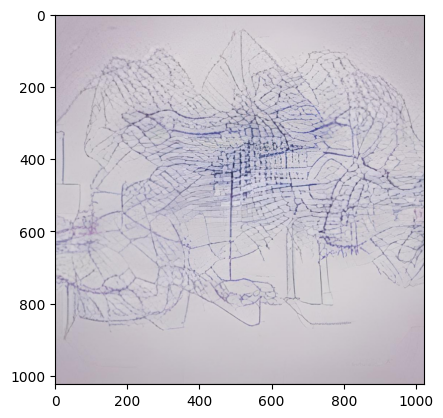

In [80]:
img2 = plt.imread("/home/asklepiad/Downloads/Neuronet.jpg")
_ = plt.imshow(img2)

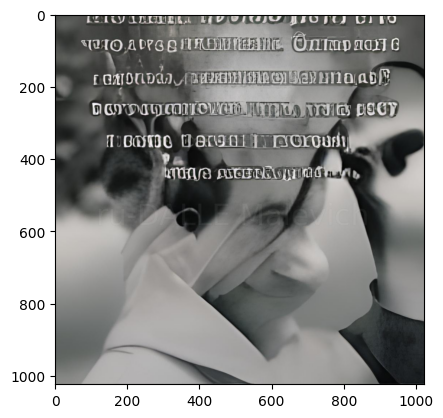

In [81]:
img3 = plt.imread("/home/asklepiad/Downloads/Confucius.jpg")
_ = plt.imshow(img3)